The purpose of this notebook is to demonstrate how to make comparisons between different sets of results.  This is demonstrated by using results of a test query to both `automat.renci.org` and `robokopkg.renci.org`.  The first sections [TRAPI query results](#TRAPI-query-results), [Cypher query results (automat.renci.org)](#Cypher-query-results-(automat.renci.org)), and [Cypher query results (robokopkg.renci.org)](#Cypher-query-results-(robokopkg.renci.org)) are to get a set of data to use for comparisons and place them in the same output directory shown in the cell immediately below.  The test case used is for `Buprenorphine` -> `any gene, process, or pathway` -> `Tremor`.

The compare_results() function is then demonstrated by taking the results from each of those first three queries and showing a Venn diagram plot showing the number of edges in common and comparison plot showing missing edges.  For this notebook, if a different query is used or a different comparison is to be made, the files being read for comparison must be specified manually.

In [48]:
from datetime import datetime
from pathlib import Path

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H%M%S")
write_dir = Path("output/compare",str(dt_string))
print(write_dir)
write_dir.mkdir(parents=True, exist_ok=True)

output\compare\2023-05-18_164704


## TRAPI query results

In [49]:
input_node_id_list

['PUBCHEM.COMPOUND:644073',
 'PUBCHEM.COMPOUND:9848990',
 'UMLS:C0524040',
 'PUBCHEM.COMPOUND:9811785',
 'UMLS:C0799646',
 'PUBCHEM.COMPOUND:91745467',
 'UMLS:C0701445',
 'PUBCHEM.COMPOUND:3033050',
 'UMLS:C0366373',
 'UMLS:C1171048']

In [50]:
import requests
import json

import pprint
pp = pprint.PrettyPrinter(indent=5)

search_string = 'Buprenorphine'
results = requests.post(f'https://name-resolution-sri.renci.org/lookup?string={search_string}&offset=0&limit=10')
results_json = results.json()
input_node_id_list = list(results_json.keys())

nn_query = {
  "curies": input_node_id_list,
  "conflate": True
}

results = requests.post('https://nodenormalization-sri.renci.org/get_normalized_nodes',json=nn_query)

query={
    "message": {
      "query_graph": {
        "edges": {
          "e00": {
            "subject": "n00",
              "object": "n01",
          "predicates":["biolink:related_to"]
          },
          "e01": {
            "subject": "n01",
              "object": "n02",
          "predicates":["biolink:related_to"]
          }
        },
        "nodes": {
          "n00": {
            "ids": ['PUBCHEM.COMPOUND:644073', 'PUBCHEM.COMPOUND:9848990'],
            "categories": ["biolink:ChemicalEntity"]
          },
          "n01": {
              "categories": ["biolink:BiologicalProcessOrActivity","biolink:Gene","biolink:Pathway"]
          },
          "n02": {
            "ids": ["HP:0001337"],
            "categories": ["biolink:DiseaseOrPhenotypicFeature"]
          }
        }
      }
    }
  }

robokop_submit_url = " http://automat-u24.apps.renci.org/robokopkg/1.3/query"
response = requests.post(robokop_submit_url,json=query)
print(response.status_code)
number_pathway_results = len(response.json()['message']['results'])
print(len(response.json()['message']['results']))

200
8


In [51]:
import pandas as pd
import os

kg = response.json()['message']['knowledge_graph']
cols = []
for node in sorted(response.json()['message']['results'][0]['node_bindings'].keys()):
    cols.append(node)
    cols.append(node + '_name')
results_df = pd.DataFrame(columns = cols)

results_list = []
for result in response.json()['message']['results']:
    result_dict = {}
    for node in sorted(result['node_bindings'].keys()):
        node_id = result['node_bindings'][node][0]['id']
        result_dict[node] = node_id
        result_dict[node + '_name'] = kg['nodes'][node_id]['name']
    # print(result_dict)

    results_list.append(pd.DataFrame([result_dict]))
results_df = pd.concat(results_list)
display(results_df)

if not os.path.exists(os.path.join(write_dir,"TRAPI")):
    os.mkdir(os.path.join(write_dir,"TRAPI"))
results_df.to_csv(os.path.join(write_dir,'TRAPI/pathways_TRAPI_automat.csv'), index=False)

combined_node_list = ["_".join([row[1].replace(" ", "_"), row[3].replace(" ", "_"), row[5].replace(" ", "_")]) for row in results_df[cols].to_numpy()]
pp.pprint(combined_node_list)

,n00,n00_name,n01,n01_name,n02,n02_name
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0200085,Limb tremor
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0002345,Action tremor
0,PUBCHEM.COMPOUND:9848990,Brixadi,NCBIGene:4988,OPRM1,HP:0012164,Asterixis
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0002322,Resting tremor
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:4988,OPRM1,HP:0012164,Asterixis
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0001337,Tremor
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0025387,Pill-rolling tremor
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0002174,Postural tremor


[    'Buprenorphine_CYP2D6_Limb_tremor',
     'Buprenorphine_CYP2D6_Action_tremor',
     'Brixadi_OPRM1_Asterixis',
     'Buprenorphine_CYP2D6_Resting_tremor',
     'Buprenorphine_OPRM1_Asterixis',
     'Buprenorphine_CYP2D6_Tremor',
     'Buprenorphine_CYP2D6_Pill-rolling_tremor',
     'Buprenorphine_CYP2D6_Postural_tremor']


In [52]:
for node_set in combined_node_list:
    print(os.path.join(write_dir,node_set+".txt"))

output\compare\2023-05-18_164704\Buprenorphine_CYP2D6_Limb_tremor.txt
output\compare\2023-05-18_164704\Buprenorphine_CYP2D6_Action_tremor.txt
output\compare\2023-05-18_164704\Brixadi_OPRM1_Asterixis.txt
output\compare\2023-05-18_164704\Buprenorphine_CYP2D6_Resting_tremor.txt
output\compare\2023-05-18_164704\Buprenorphine_OPRM1_Asterixis.txt
output\compare\2023-05-18_164704\Buprenorphine_CYP2D6_Tremor.txt
output\compare\2023-05-18_164704\Buprenorphine_CYP2D6_Pill-rolling_tremor.txt
output\compare\2023-05-18_164704\Buprenorphine_CYP2D6_Postural_tremor.txt


In [53]:
from collections import Counter
import json
import pprint
pp = pprint.PrettyPrinter(indent=5)

for i in range(number_pathway_results):
    # if i >= 1:
        # break
    print(f"Pathway result: {combined_node_list[i]}")
    edge_bindings = response.json()['message']['results'][i]['edge_bindings']
    # print(edge_bindings)

    edge_ids = []
    for edge_name, edge_list in edge_bindings.items():
        edge_ids.append({edge_name: [x['id'] for x in edge_list]})

    # print(edge_ids)
    string_out_list = []
    for edge_dict in edge_ids:
        for edge_name, edge_list in edge_dict.items():
            # print(f"{edge_name}: {edge_list}")
            for edge_id in edge_list:
                subject_id = response.json()['message']['knowledge_graph']['edges'][edge_id]['subject']
                subject = response.json()['message']['knowledge_graph']['nodes'][subject_id]['name']
                predicate = response.json()['message']['knowledge_graph']['edges'][edge_id]['predicate']
                object_id = response.json()['message']['knowledge_graph']['edges'][edge_id]['object']
                object = response.json()['message']['knowledge_graph']['nodes'][object_id]['name']
                # print(f"\t{subject} -> {predicate} -> {object}")
                string_out = f"{subject} -> {predicate} -> {object}"
                string_out_list.append(string_out)
                # if edge_name == 'e01':
                #     print(response.json()['message']['knowledge_graph']['edges'][edge_id]['attributes'])
    string_out_dict = dict(Counter(string_out_list).items())
    pp.pprint(string_out_dict)
    print("")
    
    if not os.path.exists(os.path.join(write_dir,"TRAPI")):
        os.mkdir(os.path.join(write_dir,"TRAPI"))
    with open(os.path.join(write_dir,"TRAPI",combined_node_list[i]+".txt"), 'w') as convert_file:
        convert_file.write(json.dumps(string_out_dict))
        

Pathway result: Buprenorphine_CYP2D6_Limb_tremor
{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'Buprenorphine -> biolink:regulates -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Limb tremor': 1}

Pathway result: Buprenorphine_CYP2D6_Action_tremor
{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'Buprenorphine -> biolink:regulates -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Action tremor': 1}

Pathway result: Brixadi_OPRM1_Asterixis
{    'Brixadi -> biolink:affects -> OPRM1': 1,
     'OPRM1 -> biolink:genetic_association -> Asterixis': 1}

Pathway result: Buprenorphine_CYP2D6_Resting_tremor
{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> 

## Cypher query results (automat.renci.org)

In [54]:
cypher = f"MATCH (n0_0:`biolink:ChemicalEntity`)-[r0_0]-(n1_0:`biolink:Gene`)-[r1_0]-(n2_0:`biolink:DiseaseOrPhenotypicFeature`) WHERE n0_0.name IN ['Buprenorphine'] AND n2_0.name IN ['Tremor'] RETURN [startNode(r0_0),[type(r0_0),properties(r0_0)],endNode(r0_0)] as edge_1, [startNode(r1_0),[type(r1_0),properties(r1_0)],endNode(r1_0)] as edge_2, [n0_0.name, n1_0.name, n2_0.name] as node_names LIMIT 100"

j = {'query': cypher}
results = requests.post('https://automat.renci.org/robokopkg/cypher',json=j)
results_json = results.json()
print(results_json['results'][0]['columns'])
column_names = results_json['results'][0]['columns']
print(results.status_code)

['edge_1', 'edge_2', 'node_names']
200


In [55]:
i = 0

string_out_list = []
for result in results_json['results'][0]['data']:
    j = 0
    for item in result['row'][0:2]:
        string_out_test = f"{item[0]['name']} -> {item[1][0]} -> {item[2]['name']}||{item[1][1]}"
        if string_out_test not in string_out_list:
            string_out_list.append(string_out_test)
        j = j + 1
    i = i + 1
    
combined_node_list = "_".join(results_json['results'][0]['data'][0]['row'][2]).replace(" ", "_")
print(combined_node_list)

string_out_list = [i.split('||', 1)[0] for i in string_out_list]

string_out_dict = dict(Counter(string_out_list).items())
pp.pprint(string_out_dict)

if not os.path.exists(os.path.join(write_dir,"Cypher_automat")):
    os.mkdir(os.path.join(write_dir,"Cypher_automat"))
    
with open(os.path.join(write_dir,"Cypher_automat",combined_node_list+".txt"), 'w') as convert_file:
    convert_file.write(json.dumps(string_out_dict))

Buprenorphine_CYP2D6_Tremor
{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'Buprenorphine -> biolink:regulates -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Tremor': 2}


## Cypher query results (robokopkg.renci.org)

In [56]:
from neo4j import GraphDatabase
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response
    
pw = ''
conn = Neo4jConnection(uri="bolt://robokopkg.renci.org:7687", user = 'neo4j', pwd = pw)
record_list = conn.query(cypher)

In [57]:
import os
from collections import Counter

i = 0

string_out_list = []
for record in record_list: 
    record_data = record.data()
    j = 0
    record_data_first2 = {k: record_data[k] for k in list(record_data)[:2]}
    for label, data in record_data_first2.items():
        string_out = f"{data[0]['name']} -> {data[1][0]} -> {data[2]['name']}||{data[1][1]}"
        if string_out not in string_out_list:
            string_out_list.append(string_out)
        j = j + 1

    i = i + 1

combined_node_list = "_".join(list(record_list[0].data('node_names').values())[0])
print(combined_node_list)

string_out_list = [i.split('||', 1)[0] for i in string_out_list]

string_out_dict = dict(Counter(string_out_list).items())
pp.pprint(string_out_dict)

if not os.path.exists(os.path.join(write_dir,"Cypher_robokopkg")):
    os.mkdir(os.path.join(write_dir,"Cypher_robokopkg"))
    
with open(os.path.join(write_dir,"Cypher_robokopkg",combined_node_list+".txt"), 'w') as convert_file:
    convert_file.write(json.dumps(string_out_dict))

Buprenorphine_CYP2D6_Tremor
{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'Buprenorphine -> biolink:regulates -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Tremor': 2}


## compare_results() function

Below is a demo of using `compare_results()` to compare the output from the Pathway `Buprenorphine` - `CYP2D6` - `Tremor` as extracted from the results above.  These are expected to return the same results since they queried against `automat.renci.org`.  After this first demo, a second demo will be done to show differences found between `automat.renci.org` and `robokopkg.renci.org` on the same pathway, where as of 03/29/2023, one difference is expected, being the `Buprenorphine` -> `regulates` -> `CYP2D6`.

In [58]:
import pprint
pp = pprint.PrettyPrinter(indent=5)

In [59]:
# Reading from TRAPI results
file_to_read = os.path.join(write_dir,"TRAPI","Buprenorphine_CYP2D6_Tremor.txt")
with open(file_to_read, 'r') as file:
    jsonString = file.read()
dict_trapi = json.loads(jsonString)
pp.pprint(dict_trapi)

{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'Buprenorphine -> biolink:regulates -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Tremor': 2}


In [60]:
# Reading from the Cypher (automat) query results
file_to_read = os.path.join(write_dir,"Cypher_automat","Buprenorphine_CYP2D6_Tremor.txt")
with open(file_to_read, 'r') as file:
    jsonString = file.read()
dict_cypher_automat = json.loads(jsonString)
pp.pprint(dict_cypher_automat)

{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'Buprenorphine -> biolink:regulates -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Tremor': 2}


In [61]:
# Reading from the Cypher (robokopkg) query results
file_to_read = os.path.join(write_dir,"Cypher_robokopkg","Buprenorphine_CYP2D6_Tremor.txt")
with open(file_to_read, 'r') as file:
    jsonString = file.read()
dict_cypher_robokopkg = json.loads(jsonString)
pp.pprint(dict_cypher_robokopkg)

{    'Buprenorphine -> biolink:affects -> CYP2D6': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6': 1,
     'Buprenorphine -> biolink:regulates -> CYP2D6': 1,
     'CYP2D6 -> biolink:affects -> Buprenorphine': 1,
     'CYP2D6 -> biolink:genetic_association -> Tremor': 2}


In [62]:
from datetime import datetime
from pathlib import Path

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H%M%S")
write_dir = Path("output/compare",str(dt_string))
write_dir.mkdir(parents=True, exist_ok=True)

In [63]:
# library and defining compare_results() function for later demo use
import matplotlib.pyplot as plt
import sys
!{sys.executable} -m pip install matplotlib_venn
from matplotlib_venn import venn2

def compare_results(dict_one, dict_two, output_file_name, label1, label2):
    # This function takes the results of two dictionaries created by the TRAPI and Cypher query Jupyter notebooks and gets the following:
    #  -finds how many edges each set has in common, including having the same and different number of occurrences
    #  -finds edges exclusive to each set
    #  -plots a venn diagram representation of common edges and differences between sets
    #    -edges with the same predicate but different occurrences are treated as differences in the diagram
    # INPUT:
    #  -dict_one: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -dict_two: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -output_file_name: name of the file to write to with output results
    #  -label1/label2: Text and figure label for first and second input dictionaries, respectively
    # OUTPUT:
    #  -compare .txt file listing each of the following:
    #    -Common edges
    #    -Common edge predicates with different counts
    #    -Edges exclusive to the first input dictionary
    #    -Edges exclusive to the second input dictionary
    #  -Venn diagram showing number of common and different edges between the two input sets
    with open(output_file_name, "w") as f:
        common_edge_same_list = []
        common_edge_diff_list = []
        input_one_only_list = []
        input_two_only_list = []
        for key in dict_one.keys():
            if key in dict_two.keys():
                if dict_one[key] == dict_two[key]:
                    common_edge_same_list.append(f"{key} - {dict_two[key]}")
                else:
                    common_edge_diff_list.append(f"{key}\n\t{label1} - {dict_one[key]}\n\t{label2} - {dict_two[key]}")
            else:
                input_one_only_list.append(f"{key} - {dict_one[key]}")

        for key in dict_two.keys():
            if key not in dict_one.keys():
                input_two_only_list.append(f"{key} - {dict_two[key]}")

        f.write("Common edges:\n")
        for edge in common_edge_same_list:
            f.write(edge)
            f.write("\n")
        f.write("\nCommon edges with different count:\n")
        for edge in common_edge_diff_list:
            f.write(edge)
            f.write("\n")
        f.write(f"\n{label1} only:\n")
        for edge in input_one_only_list:
            f.write(edge)
            f.write("\n")
        f.write(f"\n{label2} only:\n")
        for edge in input_two_only_list:
            f.write(edge)
            f.write("\n")
    
    venn2(subsets = (len(input_one_only_list), len(input_two_only_list), len(common_edge_same_list)+len(common_edge_diff_list)), set_labels = (label1, label2))
    plt.savefig(output_file_name.replace(".txt","_venn.png"))
    plt.show()
    
    df_merge_input = pd.DataFrame([dict_one,dict_two]).T
    df_merge_input.columns = [label1,label2]
    df_merge_input[label1][df_merge_input[label1].isnull()] = 0
    df_merge_input[label2][df_merge_input[label2].isnull()] = 0
    df_merge_input['set_difference'] = df_merge_input[label2] - df_merge_input[label1]
    display(df_merge_input)

    y = df_merge_input['set_difference']
    x = df_merge_input.index.values.tolist()
    plt.figure()
    plt.barh(x,y)
    plt.gca().invert_yaxis()
    plt.xlabel(f'{label1} vs {label2}')
    # plt.title("Automat vs ROBOKOPKG")
    # plt.tick_params(left = False, labelleft = False)
    max_set_difference = max(df_merge_input['set_difference'])
    plt.xlim([min(-3,-max_set_difference),max(3,max_set_difference)])
    plt.savefig(output_file_name.replace(".txt","_diffplot.png"), bbox_inches="tight")
    
    # set_difference = len(input_two_only_list)-len(input_one_only_list)
    # plt.figure()
    # # plt.barh(range(1),[set_difference])
    # x = [label1, label2]
    # y = [-len(input_one_only_list),len(input_two_only_list)]
    # plt.barh(x,y)
    # plt.gca().invert_yaxis()
    # # plt.xlabel(f'{label1} vs {label2}')
    # plt.xlabel("Unique edges")
    # # plt.tick_params(left = False, labelleft = False)
    # plt.xlim([min(-3,3*(-len(input_one_only_list))), max(3,3*len(input_two_only_list))])
    # plt.ylim([-3,3])
    # plt.savefig(output_file_name.replace(".txt","_diffplot.png"), bbox_inches="tight")
        

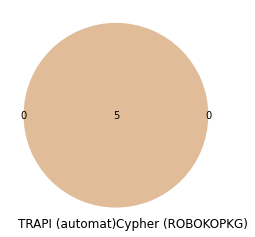

,TRAPI (automat),Cypher (ROBOKOPKG),set_difference
Buprenorphine -> biolink:regulates -> CYP2D6,1,1,0
Buprenorphine -> biolink:affects -> CYP2D6,1,1,0
Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6,1,1,0
CYP2D6 -> biolink:affects -> Buprenorphine,1,1,0
CYP2D6 -> biolink:genetic_association -> Tremor,2,2,0


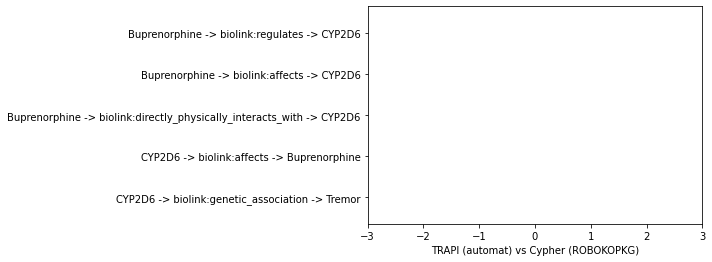

In [64]:
# Demo 1
# Compares TRAPI and Cypher (robokopkg) sets
#  -Added misspelling to TRAPI to give a unique result
#  -Also added one extra occurrence to TRAPI to demonstrate different number of occurrences

output_file_name = os.path.join(write_dir,"compare_trapi_vs_cypher-robokopkg.txt")
compare_results(dict_trapi,dict_cypher_robokopkg, output_file_name, "TRAPI (automat)", "Cypher (ROBOKOPKG)")

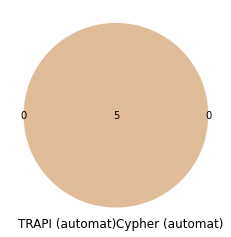

,TRAPI (automat),Cypher (automat),set_difference
Buprenorphine -> biolink:regulates -> CYP2D6,1,1,0
Buprenorphine -> biolink:affects -> CYP2D6,1,1,0
Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6,1,1,0
CYP2D6 -> biolink:affects -> Buprenorphine,1,1,0
CYP2D6 -> biolink:genetic_association -> Tremor,2,2,0


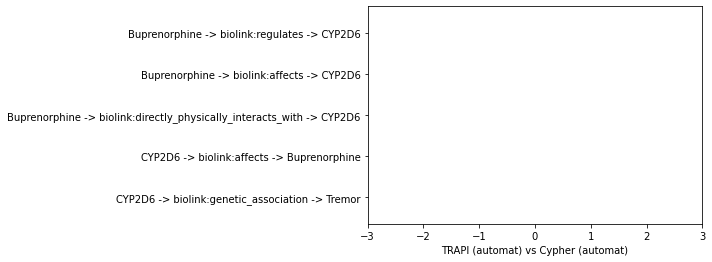

In [65]:
# Demo 2
# Compares TRAPI and Cypher (automat) sets
#  -Added misspelling to TRAPI to give a unique result
#  -Also added one extra occurrence to TRAPI to demonstrate different number of occurrences

output_file_name = os.path.join(write_dir,"compare_trapi_vs_cypher_automat.txt")
compare_results(dict_trapi, dict_cypher_automat, output_file_name, "TRAPI (automat)", "Cypher (automat)")

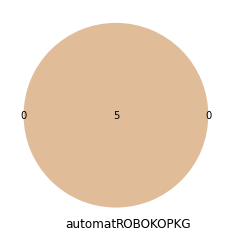

,automat,ROBOKOPKG,set_difference
Buprenorphine -> biolink:affects -> CYP2D6,1,1,0
CYP2D6 -> biolink:genetic_association -> Tremor,2,2,0
CYP2D6 -> biolink:affects -> Buprenorphine,1,1,0
Buprenorphine -> biolink:regulates -> CYP2D6,1,1,0
Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6,1,1,0


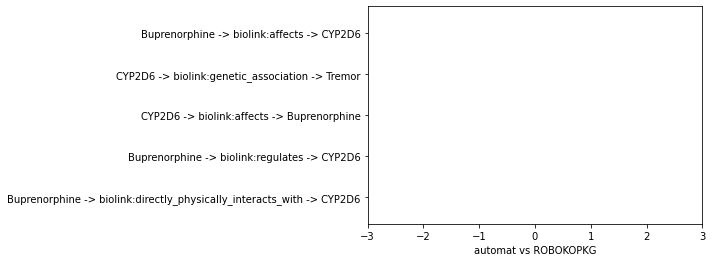

In [66]:
# Demo 3
# Compares TRAPI and Cypher (automat) sets
#  -Added misspelling to TRAPI to give a unique result
#  -Also added one extra occurrence to TRAPI to demonstrate different number of occurrences

output_file_name = os.path.join(write_dir,"compare_cypher_automat_vs_cypher_robokopkg.txt")
compare_results(dict_cypher_automat, dict_cypher_robokopkg, output_file_name, "automat", "ROBOKOPKG")

## Development section for function compare_result()

Comparing TRAPI and robokopkg output in the test folder

In [230]:
# Outputting to log file for common edges
print(f"Common edges: ")
common_edges = set(dict_trapi.items()).intersection(set(dict_cypher_robokopkg.items()))
for edge in common_edges:
    print(f"\t{edge[0]} - {edge[1]}")

Common edges: 
	CYP2D6 -> biolink:affects -> Buprenorphine - 1
	CYP2D6 -> biolink:genetic_association -> Tremor - 2


In [233]:
# Outputting to log file for common edges with different counts

for key in dict_cypher_robokopkg.keys():
    if key in dict_trapi.keys():
        if dict_cypher_robokopkg[key] == dict_trapi[key]:
            print(f"Common edge found: {key} - {dict_trapi[key]}")
        else:
            print(f"{key}\n\tCypher ROBOKOPKG - {dict_cypher_robokopkg[key]}\n\tTRAPI - {dict_trapi[key]}")
    else:
        print(f"Cypher ROBOKOPKG only: {key} - {dict_cypher_robokopkg[key]}")

for key in dict_trapi.keys():
    if key not in dict_cypher_robokopkg.keys():
        print(f"TRAPI only: {key} - {dict_trapi[key]}")

# set_cypher_kg = set(dict_cypher_robokopkg.items()).difference(set(dict_trapi.items()))
# cypher_kg_edges = set(map(lambda x: x[0], set_cypher_kg))
# cypher_kg_edges_counts = set(map(lambda x: x[1], set_cypher_kg))

# set_trapi = set(dict_trapi.items()).difference(set(dict_cypher_robokopkg.items()))
# trapi_edges = set(map(lambda x: x[0], set_trapi))
# trapi_edges_counts = set(map(lambda x: x[1], set_trapi))

Buprenorphine -> biolink:affects -> CYP2D6
	Cypher ROBOKOPKG - 1
	TRAPI: 2
Common edge found: CYP2D6 -> biolink:genetic_association -> Tremor - 2
Common edge found: CYP2D6 -> biolink:affects -> Buprenorphine - 1
Cypher ROBOKOPKG only: Buprenorphine -> biolink:regulates -> CYP2D6 - 1
Cypher ROBOKOPKG only: Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6 - 1
TRAPI only: Buprenorphine -> biolink:directctly_physically_interacts_with -> CYP2D6 - 1


In [282]:
# Outputting to log file for common edges with different counts

common_edge_same_list = []
common_edge_diff_list = []
cypher_robokopkg_only_list = []
cypher_automat_only_list = []
for key in dict_cypher_robokopkg.keys():
    if key in dict_cypher_automat.keys():
        if dict_cypher_robokopkg[key] == dict_cypher_automat[key]:
            common_edge_same_list.append(f"{key} - {dict_cypher_automat[key]}")
        else:
            common_edge_diff_list.append(f"{key}\n\tCypher ROBOKOPKG - {dict_cypher_robokopkg[key]}\n\tCypher automat - {dict_cypher_automat[key]}")
    else:
        cypher_robokopkg_only_list.append(f"{key} - {dict_cypher_robokopkg[key]}")

for key in dict_cypher_automat.keys():
    if key not in dict_cypher_robokopkg.keys():
        cypher_automat_only_list.append(f"{key} - {dict_cypher_automat[key]}")

print("Common edges:")
# pp.pprint(common_edge_same_list)
for edge in common_edge_same_list:
    print(edge)
print("\nCommon edges with different count:")
# pp.pprint(common_edge_diff_list)
for edge in common_edge_diff_list:
    print(edge)
print("\nCypher ROBOKOPKG only:")
# pp.pprint(cypher_robokopkg_only_list)
for edge in cypher_robokopkg_only_list:
    print(edge)
print("\nCypher automat only:")
# pp.pprint(cypher_automat_only_list)
for edge in cypher_automat_only_list:
    print(edge)

Common edges:
Buprenorphine -> biolink:affects -> CYP2D6 - 1
CYP2D6 -> biolink:genetic_association -> Tremor - 2
CYP2D6 -> biolink:affects -> Buprenorphine - 1
Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6 - 1

Common edges with different count:

Cypher ROBOKOPKG only:
Buprenorphine -> biolink:regulates -> CYP2D6 - 1

Cypher automat only:


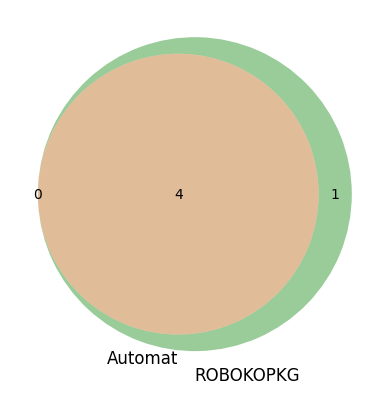

In [293]:
# library
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Use the venn2 function
venn2(subsets = (len(cypher_automat_only_list), len(cypher_robokopkg_only_list), len(common_edge_same_list)), set_labels = ('Automat', 'ROBOKOPKG'))
plt.show()

(-3.0, 3.0)

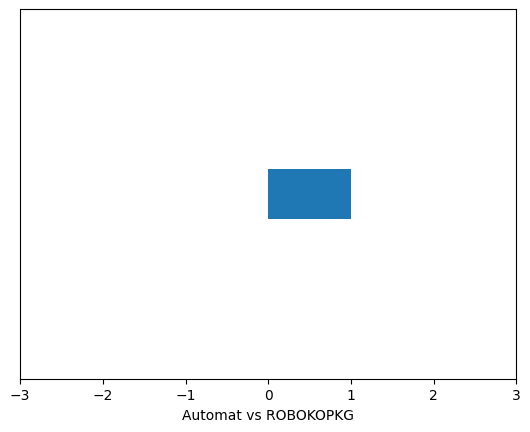

In [344]:
import numpy as np
import matplotlib.pyplot as plt

x=range(1)
set_difference = len(cypher_robokopkg_only_list) - len(cypher_automat_only_list)
y=[set_difference]
label1 = "Automat"
label2 = "ROBOKOPKG"
#plot3: barh with correct order: top-down y axis
plt.figure()
plt.barh(x,y)
plt.gca().invert_yaxis()
plt.xlabel(f'{label1} vs {label2}')
# plt.title("Automat vs ROBOKOPKG")
plt.tick_params(left = False, labelleft = False)
plt.xlim([-3, 3])
plt.ylim([-3,3])

(-12.0, 12.0)

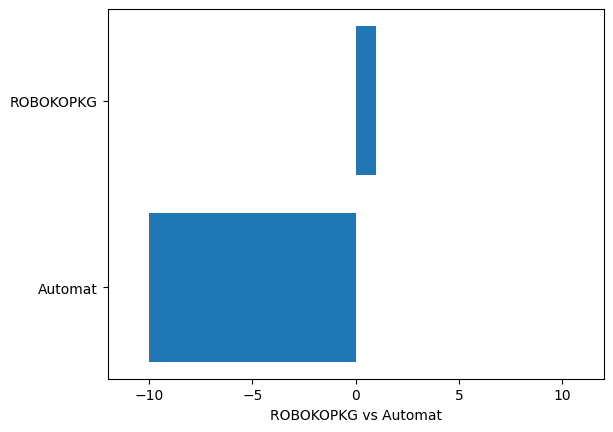

In [379]:
import numpy as np
import matplotlib.pyplot as plt

# x = range(2)
label2 = "Automat"
label1 = "ROBOKOPKG"
x = [label1,label2]
# y = [len(cypher_robokopkg_only_list),-2]
cypher_automat_only_list = range(10)
y = [len(cypher_robokopkg_only_list),-len(cypher_automat_only_list)]
#plot3: barh with correct order: top-down y axis
plt.figure()
plt.barh(x,y)
plt.gca().invert_yaxis()
plt.xlabel(f'{label1} vs {label2}')
# plt.title("Automat vs ROBOKOPKG")
# plt.tick_params(left = False, labelleft = False)
plt.xlim([min(-3,-max(len(cypher_robokopkg_only_list),len(cypher_automat_only_list))-2),max(3,max(len(cypher_robokopkg_only_list),len(cypher_automat_only_list))+2)])
# plt.xlim([-3, 3])
# plt.ylim([-3,3])

,ROBOKOPKG,Automat,set_difference
Buprenorphine -> biolink:affects -> CYP2D6,1.0,1.0,0.0
CYP2D6 -> biolink:genetic_association -> Tremor,2.0,2.0,0.0
CYP2D6 -> biolink:affects -> Buprenorphine,1.0,1.0,0.0
Buprenorphine -> biolink:regulates -> CYP2D6,1.0,0.0,-1.0
Buprenorphine -> biolink:directly_physically_interacts_with -> CYP2D6,1.0,1.0,0.0


(-3.0, 3.0)

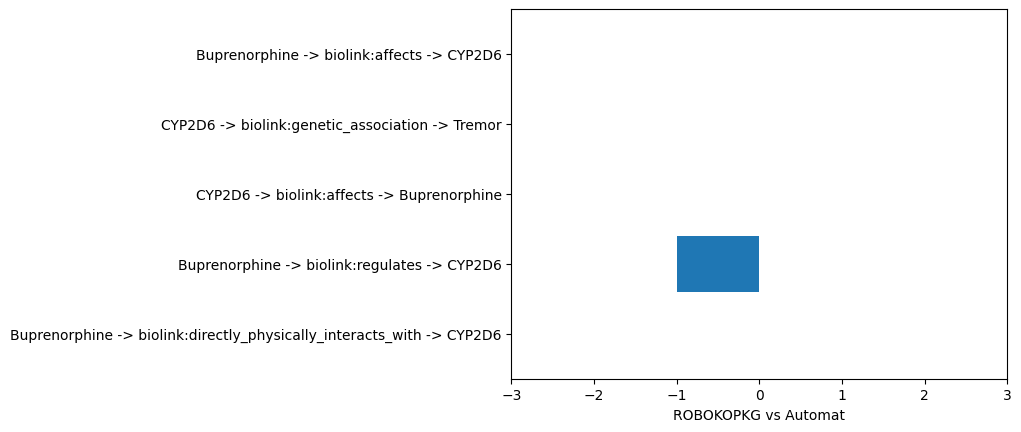

In [402]:
label1 = "ROBOKOPKG"
label2 = "Automat"

df_test_merge = pd.DataFrame([dict_cypher_robokopkg,dict_cypher_automat]).T
df_test_merge.columns = [label1,label2]
df_test_merge[label1][df_test_merge[label1].isnull()] = 0
df_test_merge[label2][df_test_merge[label2].isnull()] = 0
df_test_merge['set_difference'] = df_test_merge[label2] - df_test_merge[label1]
display(df_test_merge)

y = df_test_merge['set_difference']
x = df_test_merge.index.values.tolist()
plt.figure()
plt.barh(x,y)
plt.gca().invert_yaxis()
plt.xlabel(f'{label1} vs {label2}')
# plt.title("Automat vs ROBOKOPKG")
# plt.tick_params(left = False, labelleft = False)
max_set_difference = max(df_test_merge['set_difference'])
plt.xlim([min(-3,-max_set_difference),max(3,max_set_difference)])